# **CarND-Advanced-Lane-Lines** 
***


---

In [1]:
"""
Detecting line segments on single pictures and videos which have been made by a camera in a car. 
Programm: Udacity - Self Driving Car Engineer
Project: P4 - CarND-Advanced-Lane-Lines
Author: Daniel Gattringer (gada1982) 
"""

#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print_debug = 0



In [2]:
# Code taken from https://github.com/udacity/CarND-Camera-Calibration


def get_calibration_data():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = 'camera_cal_corners_found/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            
    return objpoints, imgpoints


def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def plot_undistort_image(image):
    objpoints, imgpoints = get_calibration_data()
    image_undist = cal_undistort(image, objpoints, imgpoints)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(image_undist)
    ax2.set_title('Undistorted Image', fontsize=25)
    ax2.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:    
    # Read in an image
    image = cv2.imread('camera_cal/calibration1.jpg')

    plot_undistort_image(image)

In [3]:
# Distort test_images

def plot_undistort_image_compare(image):
    objpoints, imgpoints = get_calibration_data()
    image_undist = cal_undistort(image, objpoints, imgpoints)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(image_undist)
    ax2.axis('off')
    ax2.set_title('Undistorted Image', fontsize=25)
    ax3.imshow(np.sum((image - image_undist)**2,axis=2),cmap='gray')
    ax3.axis('off')
    ax3.set_title('Compare images', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    image = mpimg.imread('test_images/test3.jpg')

    plot_undistort_image_compare(image)

In [4]:
# Create a binary image for one image

# TODO not used
def apply_gaussian_blur(image, kernel):
    gaussian_blur_image = cv2.GaussianBlur(image,(kernel,kernel),0)
    return gaussian_blur_image


def mag_thresh(image, kernel, mag_thresh):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)     
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary


def plot_image_with_mag_tresh(image):
    objpoints, imgpoints = get_calibration_data()
    image_undist = cal_undistort(image, objpoints, imgpoints)

    # Apply each of the thresholding functions
    mag_binary = mag_thresh(image_undist, 3, (10, 255))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.axis('off')
    ax2.set_title('mag_thresh', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # read in one test image 
    #image = mpimg.imread('test_images/test3.jpg')
    image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_mag_tresh(image)

In [5]:

def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Apply the following steps to img
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def plot_image_with_abs_sobel_thresh(image):
    objpoints, imgpoints = get_calibration_data()
    image_undist = cal_undistort(image, objpoints, imgpoints)

    ksize = 5
    thresh = (50,225)
    gradx = abs_sobel_thresh(image_hls_l, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_l, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_l = np.copy(cv2.bitwise_or(gradx, grady))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(filter_hls_l, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Abs Sobel', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # read in one test image 
    #image = mpimg.imread('test_images/test3.jpg')
    image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_mag_tresh(image)

In [6]:
# Apply Color mask

def get_color_mask(img):
    
    image_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    # White - TODO test different values
    hsv_white_l  = np.array([ 20,   0,   180])
    hsv_white_h = np.array([ 255,  80, 255])
    
    # Mask for white lanes
    mask_white = cv2.inRange(image_hsv, hsv_white_l, hsv_white_h)
    
    # Yellow - TODO test different values
    hsv_yellow_l  = np.array([ 0,  100,  100])
    hsv_yellow_h = np.array([ 50, 255, 255])
    
    # Mask for yellow lanes
    mask_yellow = cv2.inRange(image_hsv, hsv_yellow_l, hsv_yellow_h)
    
    mask_white_yellow = cv2.bitwise_or(mask_white, mask_yellow)
    
    return mask_white_yellow


def plot_image_with_color_mask(image):
    objpoints, imgpoints = get_calibration_data()
    image_undist = cal_undistort(image, objpoints, imgpoints)

    mask_yellow_white = get_color_mask(image_undist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(mask_yellow_white, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Mask yellow and white', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    #image = mpimg.imread('test_images/test3.jpg')
    image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_color_mask(image)

In [7]:
# Apply sobel filters
def get_sobel_mask(img):
    # Get image in HLS Color Space
    image_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    # Get L channel
    image_hls_l = image_hls[:,:,1]
    ksize = 5
    thresh = (50,225)
    gradx = abs_sobel_thresh(image_hls_l, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_l, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_l = np.copy(cv2.bitwise_or(gradx, grady))
    
    # Get S channel
    image_hls_s = image_hls[:,:,2]
    gradx = abs_sobel_thresh(image_hls_s, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_s, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_s = np.copy(cv2.bitwise_or(gradx, grady))
    
    return filter_hls_l, filter_hls_s

def get_combined_sobel_mask(image):
    filter_hls_l, filter_hls_s = get_sobel_mask(image)
    filter_hls_l_s = cv2.bitwise_or(filter_hls_l,filter_hls_s)
    return filter_hls_l_s


def plot_image_with_color_mask(image):
    objpoints, imgpoints = get_calibration_data()
    
    image_undist = cal_undistort(image, objpoints, imgpoints)

    filter_hls_l, filter_hls_s = get_sobel_mask(image_undist)

    filter_hls_l_s = get_combined_sobel_mask(image_undist)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Undistorted Image', fontsize=25)
    ax2.imshow(filter_hls_l, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Soble filter on L (of HSV)', fontsize=25)
    ax3.imshow(filter_hls_s, cmap='gray')
    ax3.axis('off')
    ax3.set_title('Soble filter on S (of HSV)', fontsize=25)
    ax4.imshow(filter_hls_l_s, cmap='gray')
    ax4.axis('off')
    ax4.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_color_mask(image)
    

In [8]:
# Combine Color mask (white and yellow) and sobel filters (x,y) on HLS (l and s used)
# read in one test image 

def plot_image_with_color_mask_and_sobel_HLS(image):
    objpoints, imgpoints = get_calibration_data()
    image_undist = cal_undistort(image, objpoints, imgpoints)

    mask_yellow_white = get_color_mask(image_undist)

    filter_hls_l_s = get_combined_sobel_mask(image_undist)

    image_filter_comb = cv2.bitwise_or(filter_hls_l_s, mask_yellow_white)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Undistorted Image', fontsize=25)
    ax2.imshow(mask_yellow_white, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Mask yellow and white', fontsize=25)
    ax3.imshow(filter_hls_l_s, cmap='gray')
    ax3.axis('off')
    ax3.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
    ax4.imshow(image_filter_comb, cmap='gray')
    ax4.axis('off')
    ax4.set_title('Combine color mask and soble', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_color_mask_and_sobel_HLS(image)

In [9]:
# Apply perspective transform to get Bird-Eye-View


def warp_image_int(image):
    # Get the size of the image
    image_size = np.shape(image)

    mid_y_points = int(np.uint(image_size[0] / 1.6))
    bottom_points = int(np.uint(image_size[0]) / 1.05)
    center_image = int(np.uint(image_size[1]/2))
    # TODO changenames
    ctl_window = int((center_image - (image_size[1] / 2) * 0.10))
    ctr_window = int((center_image + (image_size[1] / 2) * 0.10))
    cbl_window = int((center_image - (image_size[1] / 2) * 0.85))
    cbr_window = int((center_image + (image_size[1] / 2) * 0.85))

    points_src = [[cbl_window,bottom_points],[cbr_window,bottom_points],[ctr_window,mid_y_points],[ctl_window,mid_y_points]]
    points_dst = [[150,image_size[0]],[image_size[1]-150,image_size[0]],[image_size[1]-150,0],[150,0]]
    #points_dst = [[160,image_size[0]],[image_size[1]-160,image_size[0]],[image_size[1]-160,0],[160,0]]
    points_src_float = np.float32(points_src)
    points_dst_float = np.float32(points_dst)

    points_src_arr = np.array(points_src)
    points_dst_arr = np.array(points_dst)
    
    image_size = (image_size[1],image_size[0])
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(points_src_float, points_dst_float)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(points_dst_float, points_src_float)

    return warped, M, Minv, points_src_arr, points_dst_arr

def warp_image(image):
    
    warped, M, Minv, points_src_arr, points_dst_arr = warp_image_int(image)
    
    return warped, M, Minv

def plot_warp_image(image):
    
    objpoints, imgpoints = get_calibration_data()
    
    image_undist = cal_undistort(image, objpoints, imgpoints)
    
    warped, M, Minv, points_src_arr, points_dst_arr = warp_image_int(image_undist)
    cv2.polylines(image, [points_src_arr], True, color = (255,0,0), thickness = 3)
    cv2.polylines(warped, [points_dst_arr], True, color = (255,0,0), thickness = 3)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)   
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(warped)
    ax2.axis('off')
    ax2.set_title('Bird eye View', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    image = mpimg.imread('test_images/straight_lines2.jpg')

    plot_warp_image(image)

In [10]:
if print_debug == 1:
    # Apply perspective transform to get Bird-Eye-View
    # read in one test image 
    image = mpimg.imread('test_images/test3.jpg')

    plot_warp_image(image)

In [11]:
# Find lanes

def get_moving_average(data, N):
    mov_avg = np.convolve(data, np.ones((N,))/N, mode='valid')
    return mov_avg

def get_comb_filter(image):
    apply_gaussian = 0
    # undistort image
    objpoints, imgpoints = get_calibration_data()
    image = cal_undistort(image, objpoints, imgpoints)
    
    if apply_gaussian == 1:
        image = apply_gaussian_blur(image, 5)
    
    warped, M_warp, M_inv_warp = warp_image(image)

    mask_yellow_white = get_color_mask(warped)
    
    filter_hls_l_s = get_combined_sobel_mask(warped)
    if apply_gaussian == 1:
        filter_hls_l_s = apply_gaussian_blur(filter_hls_l_s, 25)

    image_filter_comb = cv2.bitwise_or(filter_hls_l_s, mask_yellow_white) 
    
    mean_of_lane = np.mean(image_filter_comb, axis=0)
    mean_of_lane = get_moving_average(mean_of_lane, 20)
    
    return image_filter_comb, mean_of_lane

def plot_comb_filter(image):
    image_filter_comb, mean_of_lane = get_comb_filter(image)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image_filter_comb, cmap='gray')   
    ax1.axis('off')
    ax1.set_title('Combine color mask and soble', fontsize=25)
    ax2.plot(mean_of_lane)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # Combine Color mask (white and yellow) and sobel filters
    # read in one test image 
    #image = mpimg.imread('test_images/straight_lines2.jpg')
    image = mpimg.imread('test_images/test3.jpg')

    plot_comb_filter(image)

In [12]:
'''
This function applies a mask on H and S channels in HLS Color Space
Pixels with Saturation higher than 100 and hue than lower 100 are taken

'''
def get_hls_mask(image):
    
    tresh = 100
    # Convert to HLS Color Space
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Filter H and S channel 
    image_hls_h = hls_image[:, :, 0]
    image_hls_s = hls_image[:, :, 2]
    
    # Generate mask
    mask = np.zeros_like(image_hls_h)
    mask[(image_hls_s > tresh) & (image_hls_h < tresh)] = 1
    
    return mask
'''
TODO This function applies a mask on H and S channels in HLS Color Space
Pixels with Saturation higher than 100 and hue than lower 100 are taken

'''
def get_mag_mask(image):
    #tresh = (10, 255)
    tresh = (35, 255)
    
    mag = mag_thresh(image, 3, tresh)
    # TODO try other value
    return mag

def get_comb_filter_final(image):
    # Copy image to not use the original
    objpoints, imgpoints = get_calibration_data()
    
    # undistort image
    image_undist = cal_undistort(image, objpoints, imgpoints)
    
    # Wrap image
    warped, M_warp, M_inv_warp = warp_image(image_undist)
    
    # Get HLS filter mask
    mask_hls = get_hls_mask(warped)
    
    mask_mag = get_mag_mask(warped)
    
    final_mask = np.maximum(mask_mag, mask_hls)
   
    return final_mask

def plot_comb_filter_final(image):
    image_filter_comb = get_comb_filter_final(image)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image_filter_comb, cmap='gray')   
    ax1.axis('off')
    ax1.set_title('HLS and soble', fontsize=25)
    ax2.imshow(image, cmap='gray')
    ax2.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # Combine Color mask (white and yellow) and sobel filters
    # read in one test image 
    #image = mpimg.imread('test_images/straight_lines2.jpg')
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_comb_filter_final(image)

In [13]:
# Code from Lesson Finding the lines

import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_first(binary_warped, do_print):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if do_print == 1:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, out_img
    
if print_debug == 1:
    # Combine Color mask (white and yellow) and sobel filters
    # read in one test image 
    #image = mpimg.imread('test_images/straight_lines2.jpg')
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    image_filter_comb, mean_of_lane = get_comb_filter(image)    
    left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result = find_first(image_filter_comb, 1)


In [14]:
# Code from Lesson Finding the lines

margin = 100

def find_next(binary_warped, left_fit, right_fit, do_print):   
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # TODO important
    if (len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0):
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result = find_first(image_filter_comb, 0)
        return left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    add_lines = 0
    if add_lines == 1:
        # Add left/right polynom
        warp_zero_1 = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp_1 = np.dstack((warp_zero_1, warp_zero_1, warp_zero_1))

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

        cv2.polylines(result, np.int_([pts_left]), 0, color = (255,255, 0), thickness = 7)
        cv2.polylines(result, np.int_([pts_right]), 0, color = (255,255, 0), thickness = 7)

    return left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result

if print_debug == 1:
    #image = mpimg.imread('own_test_images/project/own_test3.jpg')
    image = mpimg.imread('test_images/straight_lines1.jpg')
    image = mpimg.imread('own_test_images/project/own_test1.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    image_filter_comb, mean_of_lane = get_comb_filter(image)

    left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result = find_next(image_filter_comb, left_fit, right_fit, 1)

    ploty = np.linspace(0, image_filter_comb.shape[0]-1, image_filter_comb.shape[0] )
    plt.imshow(result)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [15]:
# Code from lesson
# Calculate curvature pix

def calculate_curvature_pix(image_filter_comb, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, image_filter_comb.shape[0]-1, image_filter_comb.shape[0] )
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    mean_curverad = (left_curverad + right_curverad) / 2
    
    return left_curverad, right_curverad, mean_curverad

if print_debug == 1:
    left_curverad, right_curverad, mean_curverad = calculate_curvature_pix(image_filter_comb, left_fit, right_fit)

    print('Left line curvature (radius pix): ', left_curverad)
    print('Right line curvature (radius pix): ', right_curverad)
    print('Mean curvature (radius pix): ', mean_curverad)
    # Example values: 1926.74 1908.48

In [16]:
# Code from lesson
# Calculate curvature real world

# TODO rework
def calculate_curvature_rw(binary_warped, left_fit_cr, right_fit_cr):
    # Define conversions in x and y from pixels space to meters
    y_calc_fac = 30 / 720 # meters per pixel in y dimension
    x_calc_fac = 3.7 / 700 # meters per pixel in x dimension
    
    image_size = np.shape(binary_warped)
    # Calculate where the lanes hit the bottom of the image
    left_bottom = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_bottom = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]

    # Next take the difference in pixels between left and right interceptor points
    road_width_in_pixels = right_bottom - left_bottom
    
    calculated_center = (left_bottom + right_bottom) / 2.0
    
    lane_deviation = (calculated_center - image_size[1] / 2.0) * x_calc_fac
    lane_deviation_round = round(lane_deviation, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    # Calculate the radius of both lane lines
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * y_calc_fac + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * y_calc_fac + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    # Calculate the mean radius of both lines
    
    # Get mean of curvatures
    mean_curverad = np.mean([left_curverad, right_curverad]) 
    
    return left_curverad, right_curverad, mean_curverad, lane_deviation_round

if print_debug == 1:
    #left_curverad, right_curverad, lane_deviation = calculate_curvature_rw_old(image_filter_comb, left_fit, right_fit, leftx, rightx)

    left_curverad, right_curverad, mean_curverad, lane_deviation = calculate_curvature_rw(image_filter_comb, left_fit_cr, right_fit_cr)
    print('Left line curvature (radius m): ', left_curverad)
    print('Right line curvature (radius m): ', right_curverad)
    print('Mean curvature (radius m): ', mean_curverad)
    print('Lane center (m): ', lane_deviation)
    # Example values: 1926.74 1908.48

/Users/daniel/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


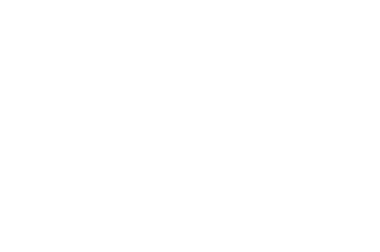

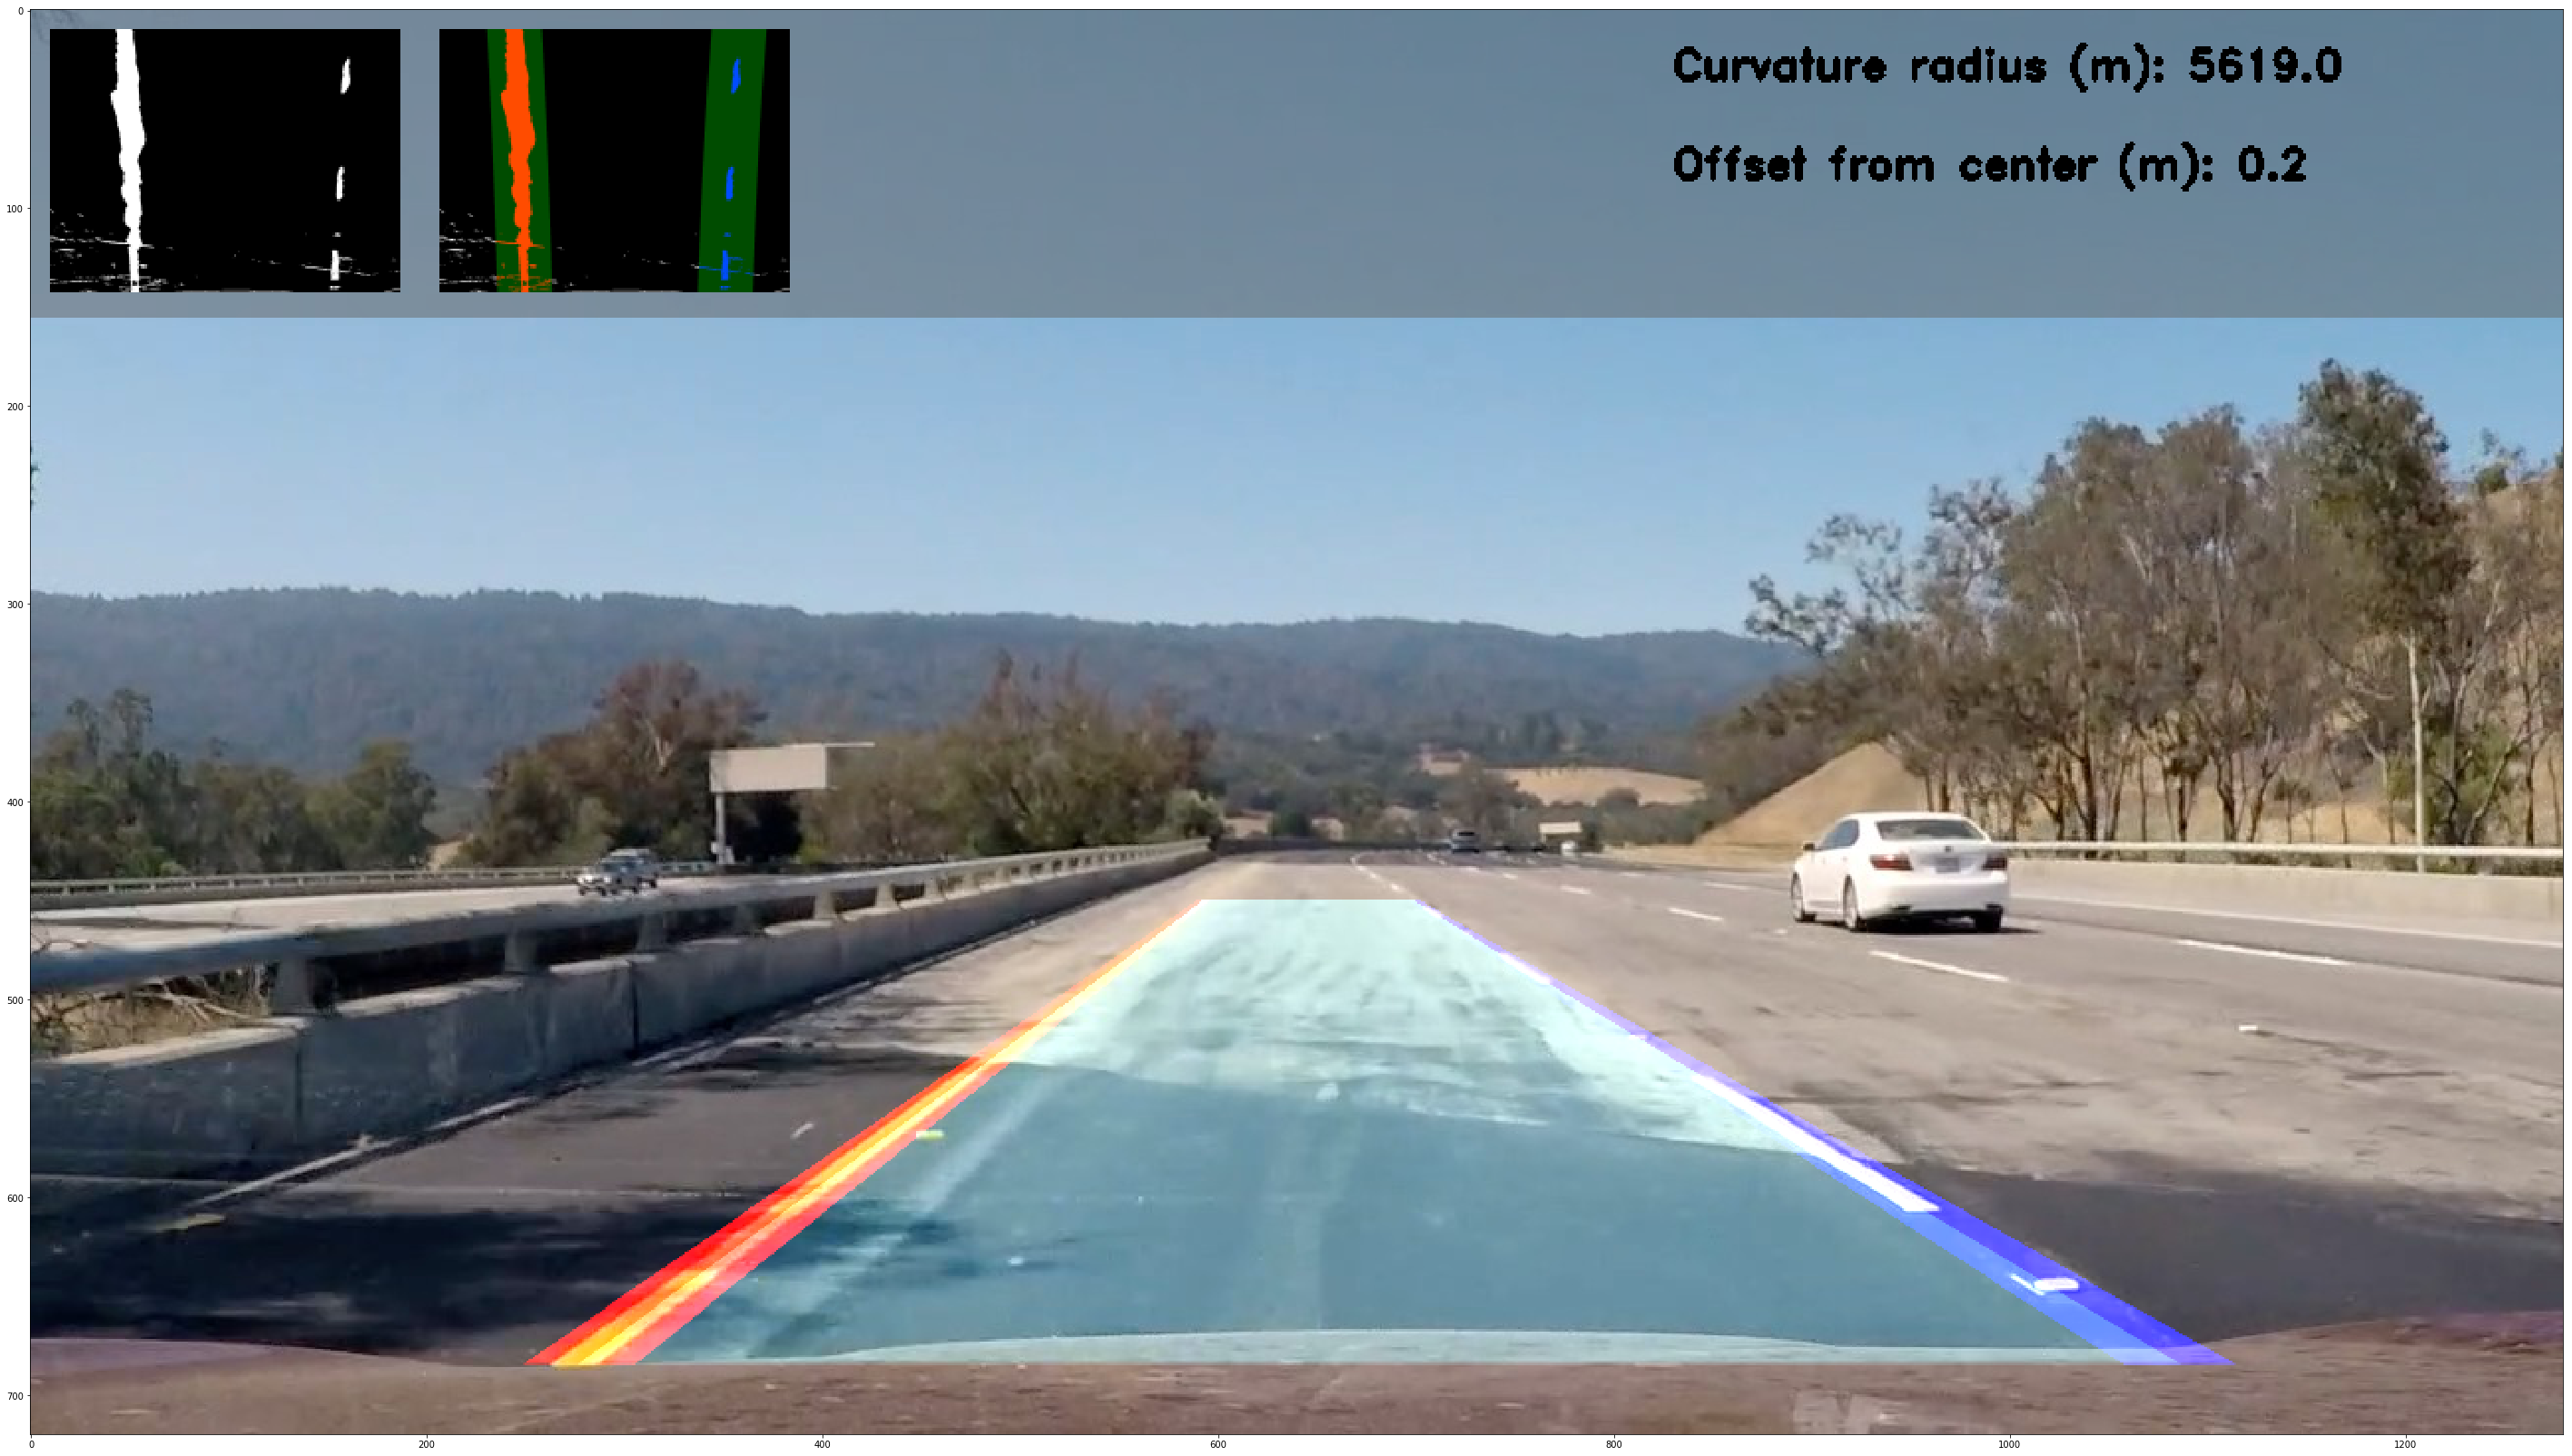

In [17]:
# Code from lesson

count = 0
left_fit = 0
right_fit = 0

def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)

prev_mean_curverad = None
prev_left_fitx = None
prev_right_fitx = None
# Create an image to draw the lines on
def generate_processed_image(image_in):
    global count
    global left_fit, right_fit
    global prev_mean_curverad, prev_left_fitx, prev_right_fitx
    
    image_size = np.shape(image_in)
    
    objpoints, imgpoints = get_calibration_data()
    
    # undistort image
    image_undist = cal_undistort(image_in, objpoints, imgpoints)
    
    # Wrap image
    dummy_1, dummy_2, M_inv_warp = warp_image(image_undist)
    
    # Weights for smother curves
    alpha_curv = 0.05
    alpha_fit = 0.2
    
    image_filter_comb = get_comb_filter_final(image_in)
    #image_filter_comb, test = get_comb_filter(image_in)
    
    warp_zero = np.zeros_like(image_filter_comb).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    warp_zero_1 = np.zeros_like(image_filter_comb).astype(np.uint8)
    color_warp_1 = np.dstack((warp_zero_1, warp_zero_1, warp_zero_1))
    
    if count == 0:
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result_filter = find_first(image_filter_comb, 0)
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result_filter = find_next(image_filter_comb, left_fit, right_fit, 0)
        count += 1
    else:
        print()
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result_filter = find_next(image_filter_comb, left_fit, right_fit, 0)    
     
    # TODO
    if prev_left_fitx is None:
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx
    else:
        left_fitx = (1 - alpha_fit) * prev_left_fitx + alpha_fit * left_fitx
        right_fitx = (1 - alpha_fit) * prev_right_fitx + alpha_fit * right_fitx
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, image_filter_comb.shape[0]-1, image_filter_comb.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (66,217, 244))
    cv2.polylines(color_warp_1, np.int_([pts_left]), 0, color = (255,0, 0), thickness = 50)
    cv2.polylines(color_warp_1, np.int_([pts_right]), 0, color = (0,0, 255), thickness = 50)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv_warp, (image_in.shape[1], image_in.shape[0])) 
    newwarp_1 = cv2.warpPerspective(color_warp_1, M_inv_warp, (image_in.shape[1], image_in.shape[0]))
    #Combine the result with the original image
    result_1 = cv2.addWeighted(image_in, 1, newwarp, 0.3, 0)
    result_1 = cv2.add(result_1,newwarp_1)
    
    left_curverad, right_curverad, mean_curverad, lane_deviation = calculate_curvature_rw(image_filter_comb, left_fit_cr, right_fit_cr)
    
    if prev_mean_curverad is None:
        prev_mean_curverad = mean_curverad
    else:
        prev_mean_curverad = (1 - alpha_curv) * prev_mean_curverad + alpha_curv * mean_curverad
        
    
    curv_mean = 'Curvature radius (m): ' + str(abs(round(mean_curverad, 0)))
    
    text_lane = 'Offset from center (m): ' + str(abs(lane_deviation))
    
    points_dst = [[0,image_size[0]-565],[image_size[1],image_size[0]-565],[image_size[1],0],[0,0]]
    points_dst_arr = np.array(points_dst)

    overlay = result_1.copy()
    
    alpha = 0.5
    cv2.fillPoly(overlay, [points_dst_arr], (100,100,100))
    cv2.addWeighted(overlay, alpha, result_1, 1 - alpha, 0, result_1)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result_1,curv_mean,(image_size[1]-450,35), font, 0.7,(0,0,0),2)
    cv2.putText(result_1,text_lane,(image_size[1]-450,85), font, 0.7,(0,0,0),2)
    
    result_1[10:143, 10:187] = cv2.resize(stack_arr(255*image_filter_comb), (177,133), interpolation=cv2.INTER_AREA)
    result_1[10:143, 207:384] = cv2.resize(result_filter, (177,133), interpolation=cv2.INTER_AREA)
    
    return result_1

do_test = 1

if do_test == 1:
    #image_p = mpimg.imread('test_images/straight_lines1.jpg')
    image_p = mpimg.imread('own_test_images/project/own_test1.jpg')
    #image_p = mpimg.imread('own_test_images/project/own_test0.jpg')
    result_filter = generate_processed_image(image_p)

    count = 0

    plt.axis('off')
    plt.figure(figsize=(50,50))
    plt.imshow(result_filter)

In [ ]:
# Test on video
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

output_file = 'processed_project_video.mp4'
input_file = 'project_video.mp4'

count = 0
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(generate_processed_image) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


  0%|          | 1/1261 [00:10<3:39:38, 10.46s/it]

  0%|          | 2/1261 [00:21<3:40:35, 10.51s/it]